### Идентификация особи

Данный ноутбук представляет обучение модели идентификации произвольной особи тигра. Несмотря на то, что по условию необходимо идентифицировать именно Принцессу, мы понимаем, что задача стоит более широкая. Поэтому мы предлагаем следующий подход, с помощью которого можно идентифицировать произвольную особь без дообучения модели.

### Входные данные

На входе мы имеем две папки с фотографиями тигров полученные фотоловушками. Одна папка содержит только фотографии Принцессы, другая - все тигры вообще. Мы обнаружили, что часть фотографий Принцессы попало в папку Train_3500, и для улучшения качества идентификации, эти фотографии необходимо будет удалить.

### Описание подхода

Наш метод заключается в том, чтобы научить модель выделять из фотографии тигра определенный вектор признаков, который можно в дальнейшем сравнивать с вектором признаков других фотографий, и определять особь по близости (использую косинусное расстояние) векторов.

Решение основано на модели resnet18. Как вы в дальнейшем убедитесь, этой модели с одной стороны хватит для эффективной идентификации, с другой стороны, она достаточно маленькая для помещения ее в embedded устройства.

Во время обучения, для каждого батча мы получаем вектор признаков из resnet18 и строим на основе него матрицу схожести использую косинусное расстояние. Целью обучения будет максимизировать значения в ячейках (i,j), где фотографии i и j представляют собой одного и того же тигра. Мы не знаем, какие особи у нас имееются в Train_3500, но знаем, на каких фотографиях представлена Принцесса.

Батч мы будем формировать следующим образом - 5 фотографий принцессы и 5 фотографий из Train_3500.

На выходе мы в идеальном варианте должны получить матрицу такого вида:

In [1]:
import numpy as np

gt_matrix = np.zeros((10, 10)).astype(int).astype(str)

for i in range(10):
    for j in range(10):
        if i < 5 and j < 5 or i == j:
            gt_matrix[i,j] = 1
        elif i < 5 or j < 5:
            gt_matrix[i,j] = 0
        else: 
            gt_matrix[i, j] = '?'

gt_matrix

array([['1', '1', '1', '1', '1', '0', '0', '0', '0', '0'],
       ['1', '1', '1', '1', '1', '0', '0', '0', '0', '0'],
       ['1', '1', '1', '1', '1', '0', '0', '0', '0', '0'],
       ['1', '1', '1', '1', '1', '0', '0', '0', '0', '0'],
       ['1', '1', '1', '1', '1', '0', '0', '0', '0', '0'],
       ['0', '0', '0', '0', '0', '1', '?', '?', '?', '?'],
       ['0', '0', '0', '0', '0', '?', '1', '?', '?', '?'],
       ['0', '0', '0', '0', '0', '?', '?', '1', '?', '?'],
       ['0', '0', '0', '0', '0', '?', '?', '?', '1', '?'],
       ['0', '0', '0', '0', '0', '?', '?', '?', '?', '1']], dtype='<U21')

Во-первых, мы видим 1 на главной диагонали. Это логично, так как каждый семпл равен сам себе.
Далее мы видим один блок с 1, это схожесть семплов принцессы.

Блоки с нулями - это различие Принцессы от остальных тигров.

И для остальных тигров по датасету мы не можем отделить одного от другого, поэтому значения там неизвестны.

Для подсчета градиентов во время обучения модели мы будем использовать только часть этой матрицы. Мы откинем часть со '?' (мы не знаем, какие значения там могут быть) и главную диагональ (нет смысла считать по ней градиенты).

Чтобы не считать лишних градиентов мы умножим полученную матрицу схожести на следующую маску:

In [2]:
grad_mask = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        if i == j: continue
        grad_mask[i,j] = (i < 5) | (j < 5)
        
        
grad_mask

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]])

Такой подход позволит нам обучить модель, которая по фотографии тигра выделяет некоторые вектор признаков, который мало зависит от освещенности и положения тигра.

<b>Важный момент.</b> На вход модель принимает вырезанные из фотографии участки, в которых находятся только тигр. В этом ноутбуке нет кода вырезания тигра. Код есть в общем скрипте эвалюации, для этой задачи используется предобученная нами модель yolo5s.

Импорты

In [4]:
import torch
import torchvision

from glob import glob

from PIL import Image

import pandas as pd

from torchvision import transforms

import numpy as np

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

In [5]:
# Загружаем базовую модель, которую будем обучать

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model = model.cuda().eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [6]:
# model.load_state_dict(torch.load('1.pt'))

In [7]:
# Функция для расчета матрицы схожести

def sim_matrix(a, b, eps=1e-8):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

In [8]:
# sanity check

result = model(torch.rand((10, 3, 224, 224)).cuda())

sim_matrix(result, result)

tensor([[1.0000, 0.9908, 0.9937, 0.9936, 0.9819, 0.9920, 0.9858, 0.9894, 0.9884,
         0.9950],
        [0.9908, 1.0000, 0.9894, 0.9848, 0.9886, 0.9899, 0.9860, 0.9843, 0.9899,
         0.9917],
        [0.9937, 0.9894, 1.0000, 0.9915, 0.9886, 0.9903, 0.9871, 0.9907, 0.9921,
         0.9933],
        [0.9936, 0.9848, 0.9915, 1.0000, 0.9786, 0.9923, 0.9884, 0.9936, 0.9880,
         0.9907],
        [0.9819, 0.9886, 0.9886, 0.9786, 1.0000, 0.9864, 0.9826, 0.9783, 0.9858,
         0.9834],
        [0.9920, 0.9899, 0.9903, 0.9923, 0.9864, 1.0000, 0.9885, 0.9922, 0.9877,
         0.9930],
        [0.9858, 0.9860, 0.9871, 0.9884, 0.9826, 0.9885, 1.0000, 0.9880, 0.9903,
         0.9845],
        [0.9894, 0.9843, 0.9907, 0.9936, 0.9783, 0.9922, 0.9880, 1.0000, 0.9848,
         0.9893],
        [0.9884, 0.9899, 0.9921, 0.9880, 0.9858, 0.9877, 0.9903, 0.9848, 1.0000,
         0.9894],
        [0.9950, 0.9917, 0.9933, 0.9907, 0.9834, 0.9930, 0.9845, 0.9893, 0.9894,
         1.0000]], device='c

Грузим датасет

In [9]:
dataset_files = glob('TigerTrain/*.jpg') + glob('TigerPrincess/*.jpg')

In [13]:
df = pd.DataFrame({'path': dataset_files})

In [14]:
# df['train'] = df.path.str.contains('train')
df['princess'] = df.path.str.contains('Princess')

Удаляем фотографии принцессы из списка остальных тигров

In [16]:
princess_in_all_tigers = pd.read_csv('princess_in_all_tigers.csv')

In [17]:
princess_images = princess_in_all_tigers['0'].str.split('/').str[-1]

In [18]:
df.path.str.split('/').str[-1].isin(princess_images).sum()

39

In [19]:
df = df[~ df.path.str.split('/').str[-1].isin(princess_images)]

Разделяем датасет на train и val

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train_df, test_df = train_test_split(df, stratify=df.princess, test_size=0.15)

In [22]:
# Во время обучения кроме стандартного препроцессинга будем делать аугментацию, для предотвращения переобучения
train_preprocess = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # Случайно зеркалим фотографию
    transforms.RandomGrayscale(), # Случайно переводим в grayscale (с вероятностью 0.1)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Во время валидации смысла в аугментации нет
test_preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [33]:
# Класс для формирования батча

class PrincessIdentificationDataset(torch.utils.data.IterableDataset):
    def __init__(self, df, n_princess, n_other, preprocess):
        self.df = df
        self.n_princess = n_princess
        self.n_other = n_other
        self.preprocess = preprocess
    
    def __iter__(self):
        princess = self.df[self.df.princess].reset_index(drop = True)
        other = self.df[~self.df.princess].reset_index(drop = True)
        
        while True:
            batch = pd.concat([princess.sample(self.n_princess), other.sample(self.n_other)])
            images = torch.stack([self.preprocess(Image.open(p)) for p in batch.path.values], axis = 0)
            
            yield images

In [34]:
train_dataset = PrincessIdentificationDataset(train_df.reset_index(drop = True), n_princess=5, n_other=5, preprocess=train_preprocess)
val_dataset = PrincessIdentificationDataset(test_df.reset_index(drop = True), n_princess=5, n_other=5, preprocess=test_preprocess)

In [35]:
val_iterator = iter(val_dataset)

In [36]:
iterator = iter(train_dataset)

In [37]:
# next(iterator)

Формируем тензор с описанной в начале ноутбука ЦЕЛЕВОЙ матрицы.

In [38]:
gt_matrix = np.zeros((10, 10))

for i in range(5):
    for j in range(5):
        if i == j: continue
        gt_matrix[i,j] = 1
        
gt_matrix = torch.tensor(gt_matrix).cuda()
gt_matrix

tensor([[0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       dtype=torch.float64)

Формируем тензор с описанной в начале ноутбука МАСКОЙ для подсчета градиентов.

In [39]:
grad_matrix = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        if i == j: continue
        grad_matrix[i,j] = (i < 5) | (j < 5)
        
        
grad_matrix = torch.tensor(grad_matrix).cuda()
grad_matrix

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]], device='cuda:0',
       dtype=torch.float64)

In [40]:
# Оптимизатор

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [41]:
# Функция обучения
# В течении определенного количества эпох считаем функцию потерь по тренировочному датасету, считаем 

def train(n_epoches, train_dataset, val_dataset, train_steps, val_steps, optim, model):
    print('Train start')
    
    def compute_loss(batch):
        features = model(batch)
        matrix = sim_matrix(features, features)*grad_matrix
        return torch.sum(torch.square(matrix - gt_matrix)) / grad_matrix.sum()
    
    best_loss = 100
    
    train_losses = []
    val_losses = []
                
    for epoch in range(n_epoches):
        print('Epoch %s' % epoch)
        
        train_iterator = iter(train_dataset)
        val_iterator = iter(val_dataset)
        
        train_loss = 0
        
        for step in tqdm(range(train_steps)):
            optim.zero_grad()
            
            train_batch = next(train_iterator).cuda()
            
            loss = compute_loss(train_batch)
            
            train_loss += loss.detach().cpu().item()
            
            loss.backward()
            
            optim.step()
            
        train_loss /= train_steps
        train_losses.append(train_loss)
        
        print('Train loss: %s' % train_loss)
        
        val_loss = 0
        
        with torch.no_grad():
            for step in tqdm(range(val_steps)):
                val_batch = next(val_iterator).cuda()
            
                loss = compute_loss(val_batch)
            
                val_loss += loss.detach().cpu().item()
                
        val_loss /= val_steps
        val_losses.append(val_loss)
                
        if best_loss > val_loss:
            best_model = model.state_dict()
                
        print('Val loss: %s' % val_loss)
        
    model.load_state_dict(best_model)
    
    print('Best val loss: %s' % best_loss)
    
    return train_losses, val_losses

In [42]:
train_losses, val_losses = train(20, train_dataset, val_dataset, len(train_df) // 10, len(test_df)//10, optim, model)

Train start
Epoch 0


/tmp/ipykernel_44312/2123865211.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(train_steps)):


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.22174614132900392


/tmp/ipykernel_44312/2123865211.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(val_steps)):


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.22049096890354383
Epoch 1


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.20868866776148062


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.19618768950863902
Epoch 2


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.1797613350196909


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.173498770361967
Epoch 3


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.172849286045323


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.3034010824799197
Epoch 4


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.16407745922657935


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.1456555743799705
Epoch 5


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.1482528086341993


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.18024296974684384
Epoch 6


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.1535508417529533


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.19495652044875966
Epoch 7


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.14919931032079048


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.13344764277885388
Epoch 8


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.14349576681861229


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.12555398571817963
Epoch 9


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.13263928039970316


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.14574054495609623
Epoch 10


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.12578223382595166


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.18055767362735195
Epoch 11


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.12913388763726052


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.11325597846438873
Epoch 12


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.12488769075354832


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.1424194877936073
Epoch 13


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.11338717155207127


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.12286860107583474
Epoch 14


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.11487993113777326


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.13917416353243944
Epoch 15


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.10946843072626802


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.13496005459613403
Epoch 16


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.10042114958285114


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.1807232681148684
Epoch 17


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.10276885886734091


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.11462990104008096
Epoch 18


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.10741452176403711


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.10317964129978519
Epoch 19


  0%|          | 0/329 [00:00<?, ?it/s]

Train loss: 0.09581232857132567


  0%|          | 0/58 [00:00<?, ?it/s]

Val loss: 0.06642758401685278
Best val loss: 100


In [43]:
torch.save(model.state_dict(), '3.pt')

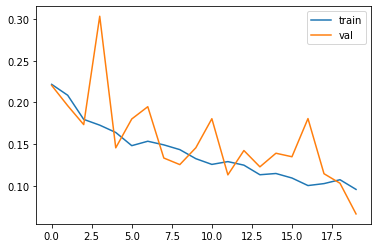

In [44]:
# Рисуем графики лосса

plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train', 'val'])

### Демо матрицы схожести

In [45]:
batch = next(val_iterator)

In [46]:
features = model(batch.cuda())

In [47]:
features

tensor([[  5.2240, -13.8796, -30.2200,  ...,  -9.4917, -15.2828,  29.8513],
        [  3.3925, -36.4286, -57.5035,  ...,  -9.1192, -47.1152,  77.6464],
        [ -2.1258, -17.8593, -26.0393,  ..., -15.0359, -26.1332,  39.1468],
        ...,
        [-13.0194,  -4.0068,  -4.3584,  ...,  -9.4941,   5.1701,  24.8410],
        [-13.0507,  -6.1451,  -1.6279,  ...,  -4.4486,  -4.0274,  31.8529],
        [ -7.0783,  -3.7504,  11.6259,  ...,  -1.6647,  -2.2972,   0.9199]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [48]:
matrix = sim_matrix(features, features)

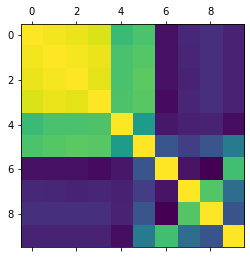

In [49]:
plt.matshow(matrix.detach().cpu().numpy())

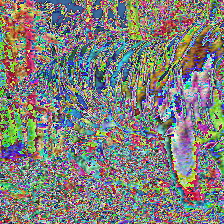

In [50]:
transforms.ToPILImage()(batch[5])

### Считаем фичи принцессы

In [52]:
princess_features = []

with torch.no_grad():
    for _, row in tqdm(train_df[train_df.princess].iterrows()):
        img = Image.open(row.path)
        img = test_preprocess(img).unsqueeze(dim = 0).cuda()
        feature = model(img)[0].cpu().numpy()
        princess_features.append(feature)

/tmp/ipykernel_44312/542031797.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, row in tqdm(train_df[train_df.princess].iterrows()):


0it [00:00, ?it/s]

In [53]:
import pickle

In [54]:
with open('princess_features_0.pkl', 'wb') as f:
    pickle.dump(princess_features, f)

In [55]:
princess_features_sim_matrix = sim_matrix(torch.tensor(princess_features),torch.tensor(princess_features))

/tmp/ipykernel_44312/2596468552.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  princess_features_sim_matrix = sim_matrix(torch.tensor(princess_features),torch.tensor(princess_features))


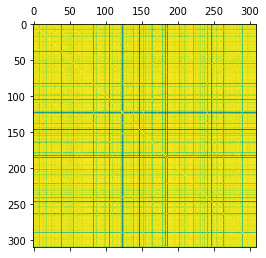

In [56]:
plt.matshow(princess_features_sim_matrix.numpy())

In [57]:
princess_features_sim_matrix.mean(axis = 0).mean()

tensor(0.8904)

Как видим, большинство фичей принцессы очень близки друг к другу. В среднем среднее расстояние до фича вектора принцессы равно 0.8645

# Валидация и поиск порога

In [58]:
val_features = []
val_classes = []

with torch.no_grad():
    for _, row in tqdm(test_df.iterrows()):
        img = Image.open(row.path)
        img = test_preprocess(img).unsqueeze(dim = 0).cuda()
        feature = model(img)[0].cpu().numpy()
        val_features.append(feature)
        val_classes.append(int(row.princess))
        
val_classes = np.array(val_classes)

/tmp/ipykernel_44312/2020401355.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, row in tqdm(test_df.iterrows()):


0it [00:00, ?it/s]

In [59]:
val_sim_matrix = sim_matrix(torch.tensor(princess_features), torch.tensor(val_features)).cpu()

In [60]:
scores = val_sim_matrix.mean(axis = 0).numpy()

In [61]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

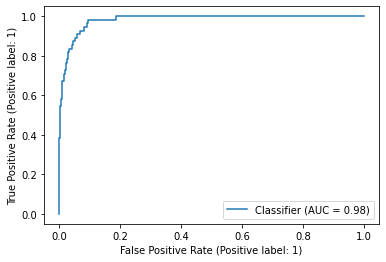

In [62]:
RocCurveDisplay.from_predictions(val_classes, scores)

In [63]:
thr = []

thresholds = scores.copy()
thresholds.sort()

for t in tqdm(thresholds):
    t_princess = scores >= t
    trues = (t_princess == val_classes)
    falses = (t_princess != val_classes)
    thr.append(trues[val_classes == 1].sum()*2 - falses.sum())
    

/tmp/ipykernel_44312/20057364.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for t in tqdm(thresholds):


  0%|          | 0/582 [00:00<?, ?it/s]

Максимальный скор и порог

In [69]:
max(thr), thresholds[np.argmax(thr)]

(66, 0.67029667)

Зависимость скора от порога

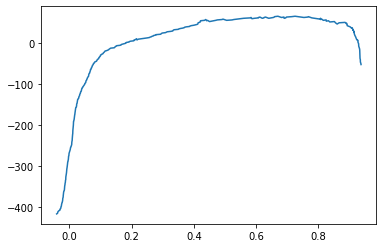

In [70]:
plt.plot(thresholds, thr)